# Classifier performance (Fig 7)

In [1]:
import h5py


from qutip.wigner import qfunc

import numpy as np

from sklearn.metrics import accuracy_score


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from qst_nn.models.classifier import Classifier
from qst_nn.data.preprocess import remove_data, remap_labels, normalize
from qst_nn.training.train_classifier import loss, optimizer
from qst_nn.utils import plot_confusion_matrix, plot_three_husimi, cat



import os
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

os.environ["CUDA_VISIBLE_DEVICES"] = ""
tf.keras.backend.set_floatx('float32')

# Set the figure options and size

In [2]:
# https://scipy-cookbook.readthedocs.io/items/Matplotlib_LaTeX_Examples.html
fig_width_pt = 246.0  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inch
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
fig_size =  [fig_width,fig_height]
params = {# 'backend': 'ps',
          'axes.labelsize': 8,
          'font.size': 8,
          'xtick.labelsize': 8,
          'ytick.labelsize': 8,
          'axes.labelpad': 1,
          'text.usetex': False,
          'figure.figsize': fig_size,}
plt.rcParams.update(params)

# Load the data from the test data file

In [3]:
xgrid = 32
ygrid = 32

xvec = np.linspace(-5, 5, xgrid)
yvec = np.linspace(-5, 5, ygrid)

datapath = "data/"

with h5py.File(datapath+"test.h5", 'r') as f:
    xdata_test = f["x"][()]
    ydata_test = f["y"][()]
    
# Data shapes
print("Test x-data shape", xdata_test.shape)
print("Test y-data shape", ydata_test.shape)

xdata_test, ydata_test = remove_data(xdata_test, ydata_test, 3)
ydata_test = remap_labels(ydata_test)


# Any other preprocessing or removal of the data should be done before this step
x_test, y_test = xdata_test.reshape((-1, xgrid, ygrid, 1)), ydata_test.reshape((-1,1))

Test x-data shape (10000, 1024)
Test y-data shape (10000, 1)


# Construct the data generator and the classifier network from saved model

In [4]:
test_data_generator = ImageDataGenerator(
            featurewise_center=False,
            featurewise_std_normalization=False,
            samplewise_std_normalization=False,
            samplewise_center=False,
            rotation_range=0,
            width_shift_range=0,
            height_shift_range=0,
            horizontal_flip=False,
            vertical_flip=False,
            shear_range=0,
            zoom_range=0,
            preprocessing_function=normalize
)

classifier = Classifier()
classifier.compile(optimizer=optimizer,
                   loss=loss,
                   metrics=['accuracy'])


# Load the model's weights
checkpoint_path = "classifier/"
checkpoint_dir = os.path.dirname(checkpoint_path)
classifier.load_weights(checkpoint_path)

2021-09-24 14:54:50.214579: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
classifier.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 30, 30, 32)        288       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9216      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 28, 28, 32)        0         
_________________________________________________________________
gaussian_noise (GaussianNois (None, 28, 28, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 32)        0     

# Make predictions on the test data and evaluate the model

In [6]:
batch_size = 128

test_data_gen = test_data_generator.flow(x_test, y_test, batch_size=batch_size, shuffle=False)
y_pred = classifier.predict(test_data_gen)
y_pred = np.argmax(y_pred, 1)
print("Accuracy", accuracy_score(y_pred, y_test))

2021-09-24 14:54:50.626426: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Accuracy 0.9860438292964244


# Confusion matrix

Normalized confusion matrix


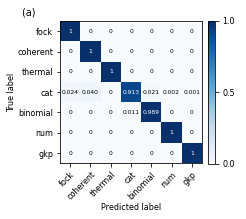

In [10]:
state_labels = ['fock', 'coherent', 'thermal', 'cat', 'binomial', 'num', 'gkp']

fig, ax = plt.subplots(1, 1, figsize=(fig_width,
                                      fig_width),
                       sharex=False, sharey=False)

plot_confusion_matrix(y_test, y_pred, classes = state_labels, normalize=True,
                     fig=fig, ax=ax,
                      title="(a)                                                                    ")
plt.tight_layout()
plt.show()

# # plt.savefig("fig-7a-confusion.pdf", bbox_inches="tight", pad_inches=0.)

# Misclassifications of a cat state

['fock', 'binomial', 'coherent']


/Users/shahnawaz/Dropbox/phd/tomography/manuscript/code/qst-nn/qst_nn/utils.py:234: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax[0].pcolor(xvec, yvec, d1,
/Users/shahnawaz/Dropbox/phd/tomography/manuscript/code/qst-nn/qst_nn/utils.py:238: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax[1].pcolor(xvec, yvec, d2,
/Users/shahnawaz/Dropbox/phd/tomography/manuscript/code/qst-nn/qst_nn/utils.py:242: MatplotlibDeprecationWarning: shading='flat' when 

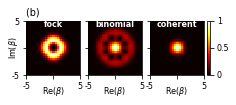

In [11]:
cat1 = qfunc(cat(32, 1, 1, mu=1), xvec, yvec, g=2)
cat2 = qfunc(cat(32, 2, 3, mu=0), xvec, yvec, g=2)
cat3 = qfunc(cat(32, 1, 3, mu=0), xvec, yvec, g=2)

data = np.array([normalize(d).reshape((xgrid, xgrid, 1)) for d in [cat1, cat2, cat3]])
predictions = classifier.predict(data)

reverse_mapping_correct = {
          0:"fock",
         1:"coherent",
         2:"thermal",
         3:"cat",
         4:"binomial",
         5:"num",
         6:"gkp"
          }

titles = [reverse_mapping_correct[l] for l in np.argmax(tf.nn.softmax(predictions), 1)]

fig, ax = plot_three_husimi(cat1, cat2, cat3, title="(b)                                                         ", cmap="hot")

ax[0].text(0.5, 0.89, titles[0], fontweight="bold", ha='center', 
          transform=ax[0].transAxes, fontsize=8, color="white",)

ax[1].text(0.5, 0.89, titles[1], fontweight="bold", ha='center', 
          transform=ax[1].transAxes, fontsize=8, color="white",)

ax[2].text(0.5, 0.89, titles[2], fontweight="bold", ha='center', 
          transform=ax[2].transAxes, fontsize=8, color="white",)

plt.show()